(proj2_analysis)=
# Project 2 Part 2: Analysis

:::{epigraph}
Observational Studies

-- TODO your name here
:::

:::{admonition} Collaboration Statement
- TODO brief statement on the nature of your collaboration.
- TODO your collaborator's names here
:::

## Part 2 Table of Contents and Rubric

| Section | Points |
|------------------------------------|-------|
| Visualizing trimming effects | 1 |
| Study design: Lalonde | 1.5 |
| Estimation and interpretation: Lalonde | 2 |
| Reflection | 0.5 |
| Total | 5 pts

:::{note} Grading guidelines

The course projects offer an opportunity to practice the full causal inference workflow, from building estimators and formulating questions to conducting analyses and communicating your findings effectively. Here are some guidelines on how to approach the project:

- For visualizations:
    - Help your reader understand your findings through visually clear figures
    - Label your axes, provide legends when appropriate, and add figure titles to provide context

- For written responses:
    - Support your ideas with specific evidence from your analysis or prior knowledge
    - Write concisely but clearly -- one-word/one-phrase answers usually don't give enough space to show what you've learned

If you're uncertain about any portion of the project, please do come to office hours, TA hours, or reach out on Ed! 

:::

# Notebook and function imports

:::{tip}

If you click on the vertical blue bar on the left of a cell, you can collapse the code which can help organize the notebook as you work through the project.

:::

If you have tested your implementation in Part 1 against the autograder, you would have generated a file called `proj2_functions.py`. Let's now import those functions into this notebook for use in Part 2. 

If you are running this notebook on the JupyterHub allocated for the course:

1. Open the file browser by going to the menu bar "View -> File Browser"
2. Navigate to `comsc341cd.github.io/projects/`, you should see your `proj2_analysis.ipynb` file in that folder
3. Click on the upload button in the upper right and upload the `proj2_functions.py` file to this directory
4. Run the following cell to import the functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import ipywidgets as widgets

from ipywidgets import interact_manual

from proj2_functions import *

rng = np.random.RandomState(42)

ModuleNotFoundError: No module named 'proj2_functions'

We have provided implementations of `bootstrap_ci` and `bootstrap_dfs` from Project 1, as well as `reg_diff_in_means` which uses linear regression to estimate difference-in-means below:

:::{note}

The fact that our matching estimator matches **without** replacment is critical for making our bootstrap confidence intervals valid. For the statistically curious, you can see [Austin and Small 2014: The use of bootstrapping when using propensity-score matching without replacement: a simulation study](https://pmc.ncbi.nlm.nih.gov/articles/PMC4260115/) for a detailed exploration of why.

:::

In [2]:
def bootstrap_ci(bootstrap_values, alpha=0.05):
    """
    Computes the confidence interval using the percentile method.

    Args:
        bootstrap_values (list[float]): the bootstrapped values
        alpha (float): the significance level, defaults to 0.05

    Returns:
        list[float]: the confidence interval [lower, upper]
    """
    lower = np.percentile(bootstrap_values, alpha * 100)
    upper = np.percentile(bootstrap_values, (1 - alpha) * 100)
    return [lower, upper]


def bootstrap_dfs(df, n_bootstraps=10000):
    """
    Bootstraps the dataframe `n_bootstraps` times.

    Args:
        df (pd.DataFrame): the dataframe to bootstrap
        n_bootstraps (int): the number of bootstraps to generate

    Returns:
        list[pd.DataFrame]: a list of bootstrapped dataframes
    """
    bootstrap_dfs = []

    for i in range(n_bootstraps):
        bootstrap_dfs.append(df.sample(frac=1, replace=True))

    return bootstrap_dfs


def reg_diff_in_means(data, outcome_col, treat_col):
    """
    Computes the difference in means between the treatment and control groups using a regression model.

    Args:
        data (pd.DataFrame): the dataframe containing the data
        outcome_col (str): the name of the outcome variable
        treat_col (str): the name of the treatment variable

    Returns:
        float: the difference in means between the treatment and control groups
    """
    reg_result = smf.ols(f'{outcome_col} ~ 1 + {treat_col}', data=data).fit()
    return reg_result.params[treat_col]


We have also provided a helper function called `generate_estimates()` that will compute both the point estimate and bootstrapped confidence interval for any estimator function you pass to it. Read through the docstring and the code below to make sure you understand how it works:

In [3]:
def generate_estimates(data, estimator_func, treat_col, outcome_col, n_bootstraps=2000):
    """
    Computes the point estimate the and bootstrapped 95% confidence interval for an estimator function.

    Args:
        data (pd.DataFrame): the dataframe containing the data
        estimator_func (function): the estimator function to use
        treat_col (str): the name of the treatment variable
        outcome_col (str): the name of the outcome variable
        n_bootstraps (int): the number of bootstraps to use

    Returns:
        dict: a dictionary containing the point estimate, bootstrapped confidence interval, and bootstrapped values
    """
    # compute the point estimate
    point_estimate = estimator_func(data, treat_col=treat_col, outcome_col=outcome_col)
    
    # generate the bootstrap samples
    bootstrap_samples = bootstrap_dfs(data, n_bootstraps)
    # compute the bootstrap estimates
    bootstrap_values = []

    for bootstrap_sample in bootstrap_samples:
        bootstrap_values.append(estimator_func(bootstrap_sample, treat_col=treat_col, outcome_col=outcome_col))
    
    # compute the confidence interval, which is a list of two floats
    ci = bootstrap_ci(bootstrap_values, alpha=0.05)
    
    return {'point_estimate': point_estimate, 'ci': ci, 'bootstrap_values': bootstrap_values}

For example, if we had a dataset `df` with treatment column `T` and outcome column `Y`, we could compute the point estimate and 95% confidence interval for the difference-in-means estimator as follows:

```python
diff_in_means_results = generate_estimates(data=df, estimator_func=reg_diff_in_means, treat_col='T', outcome_col='Y')
```

# 1. Simulation study: effects of trimming

We provide a simulated observational study dataset in `~/COMSC-341CD/data/sim_observational_study.csv`, with a true ATT of 1, and the true propensity score given by the `propensity_score` column.

Complete the widget below to explore the effect of trimming the propensity score on the balance and estimate distribution. The `plot_balance_and_estimate_distribution()` function will generate three plots on one row: 

- `axs[0]` will show the overlap in the propensity score distribution between the treated and control groups in the trimmed dataset
- `axs[1]` will show the overlap in the propensity score distribution between the treated and control groups in the trimmed dataset after matching has been performed
- `axs[2]` will show the distribution of the ATT estimate for the matched dataset, compared to the true ATT of 1

Be sure to label the axes and add a title to each plot.

In [2]:
# TODO add an interact_manual decorator for lower_bound and upper_bound, in increments of 0.1
# @interact_manual(TODO)
def plot_balance_and_estimate_distributions(lower_bound=0.0, upper_bound=1):
    """
    Plots the trimmed distribution, matched distribution, and the ATT estimate distribution for a dataset given a lower and upper bound trimming of the propensity score.

    Args:
        lower_bound (float): the lower bound of the propensity score
        upper_bound (float): the upper bound of the propensity score
    """
    assert lower_bound < upper_bound, "Lower bound must be less than upper bound"

    # Load in the simulated dataset, note that is already has a 'propensity_score' column
    data = pd.read_csv("~/COMSC-341CD/data/sim_observational_study.csv")

    # TODO trim the data_df with the lower and upper bounds
    # trimmed_df = None
    # TODO match the trimmed dataset
    # matched_df = None
    # TODO generate results for the matched dataset
    # matched_results = generate_estimates(data=TODO, estimator_func=reg_diff_in_means, treat_col='T', outcome_col='Y')

    # generate 3 plots on one row
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    #### axs[0] ####
    # TODO plot the propensity score distribution of trimmed_df on axs[0], where x='propensity_score' and hue='T'
    # sns.kdeplot(TODO)

    # fix the x-axis for easier comparison
    axs[0].set_xlim(0, 1)


    #### axs[1] ####
    # TODO plot the propensity score distribution of trimmed_df on axs[1], where x='propensity_score' and hue='T'
    # sns.kdeplot(TODO)

    # fix the x-axis for easier comparison
    axs[1].set_xlim(0, 1)


    #### axs[2] ####
    # TODO plot the ATT estimate distribution on axs[2] as a histogram, using matched_results['bootstrap_values']
    # sns.histplot(TODO)

    # TODO plot vertical lines for the estimated ATT using matched_results['point_estimate']

    # TODO plot a vertical line for the true ATT, which is x=1

    # fix the x-axis for easier comparison
    axs[2].set_xlim(-1, 3)

    fig.legend()

:::{note}

If the bounds are too narrow, the widget may throw an error due to no control units being found for some treated units during matching. That is to be expected, and does not indicate an issue with your code.

:::

Answer the following questions based on the widget above:

1.1. When there is no trimming (lower_bound = 0 and upper_bound = 1), what do you observe about the ATT estimate (right plot)? Does the estimated effect appear to be biased? Looking at the non-matched propensity score distribution (left plot), what do you observe about potential overlap concerns with the treated and control groups? 

1.2. Holding the upper bound constant at 1, what do you observe about the ATT distribution (right plot) and the matched propensity score distribution (middle plot) as you vary the lower bound?

1.3. Holding the lower bound constant at 0, what do you observe about the ATT distribution (right plot) and the matched propensity score distribution (middle plot) as you vary the upper bound?

1.4. Based on the matched propensity score distribution and the ATT distribution, what appears to be a reasonable upper and lower bound for trimming the propensity score? 

**TODO your responses below**:

1.1.

1.2.

1.3. 

1.4. 


---

# The Lalonde Study

[Lalonde (1986)](https://www.jstor.org/stable/1806062?seq=1) was a landmark study in causal inference, as it aimed to compare non-experimental observational methods of estimating causal effects to those from a randomized experiment. It analyzed data from the National Supported Work Demonstration (NSW) program, where participants across the United States were randomly assigned to the job-training program.

## Prior Knowledge and Causal Question

Below is a description of the NSW program adapted from [Cunninngham 2021](https://mixtape.scunning.com/) and [Manpower Demonstration Research Corporation 1983](https://www.mdrc.org/sites/default/files/full_249.pdf):

> The National Supported Work Demonstration (NSW) job-training program was operated by the Manpower Demonstration Research Corp (MDRC) in the mid-1970s. The NSW was a temporary employment program designed to help individuals facing employment barriers develop basic job skills and transition into the labor market by providing work experience and counseling in a supportive environment. It was also unique in that it randomly assigned eligible applicants to training positions. The treatment group received all the benefits of the NSW program. The comparison group did not receive these benefits. The program served women receiving Aid to Families with Dependent Children, people in recovery from substance use disorders, formerly incarcerated individuals, and adults who had not completed high school. The sites were located in 15 different locations across the United States:

<div style="max-width:500px; margin: auto;"> 

![](../images/proj2_mdrc_locations.png)

</div>

> Treatment group participants were provided a job for nine to eighteen months depending on the target group and site. They were organized into crews of three to five participants who worked together and met frequently with an NSW counselor to discuss concerns about the program and performance. Additionally, they received compensation for their work. NSW offered the participants initial wages that were lower than standard employment rates, but included opportunities for earnings to increase based on satisfactory performance and attendance. After participants completed their terms, they needed to secure regular employment. The types of jobs varied within sites—some worked as gas-station attendants, some worked at a printer shop—and the work assignments often differed between men and women.

The causal question of interest is whether the National Supported Work Demonstration program (NSW) deployed in 1976-77 had an effect on the participants' 1978 earnings, and the causal quantity that is targeted is the average treatment effect on the treated (ATT):

$$
ATT = \mathbb{E}[Y(1) - Y(0) \mid T = 1]
$$

- treatment $T$: whether the participant was in the NSW program
- outcome $Y$: the participant's earnings in 1978

Lalonde and subsequent researchers constructed two datasets: an experimental dataset where the treatment was randomly assigned, and an observational dataset built from other national survey data to serve as controls. We can therefore use the experimental dataset to estimate the causal effect of the treatment as the "true" ATT effect, and use it to compare the performance of our observational methods.

In particular, there are the following variables in the dataset:

- `re78`: **outcome**: the participant's **re**al (inflation-adjusted) earnings in 1978
- `treat`: **treatment**: whether the participant was in the NSW program
- `u74`: whether the participant was unemployed in 1974
- `u75`: whether the participant was unemployed in 1975
- `re74`: the participant's real earnings in 1974
- `re75`: the participant's real earnings in 1975
- `black`: whether the participant is black
- `hisp`: whether the participant is Hispanic
- `marr`: whether the participant is married
- `nodegree`: whether the participant has a high school degree
- `age`: the participant's age
- `educ`: the participant's education level as a number of years of schooling (e.g. 12 for high school graudate, 16 for college graduate)

## Design

**Figure 1**: Load in the observational dataset and fit a propensity score model to assess positivity and overlap. Complete the code cell below to create two histogram plots side-by-side, where the left plot shows the overall shape of the propensity score distribution, and the right plot zooms in using [axes.set_ylim()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html) to get a better view of overlap.


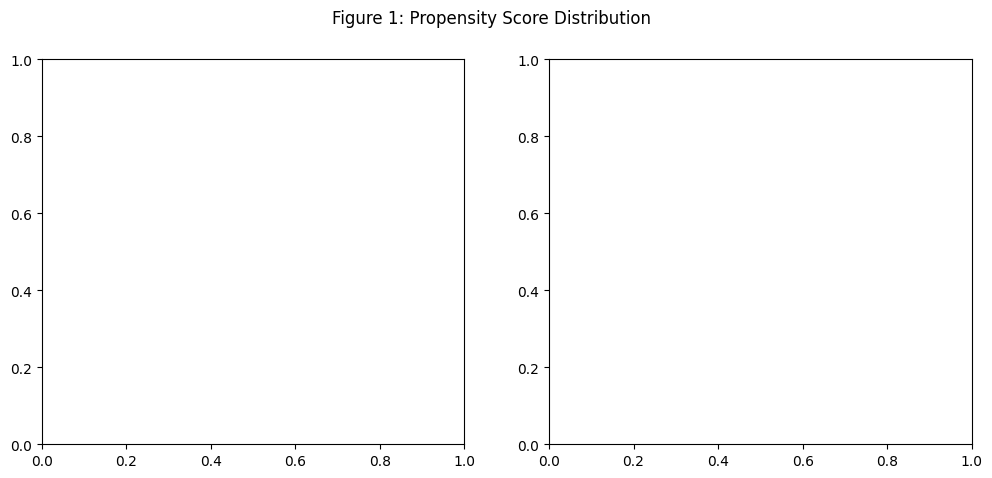

In [3]:
observational_df = pd.read_csv('~/COMSC-341CD/data/nsw_observational.csv')
covariates = ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75', 'u74', 'u75']

# TODO fit propensity score model and create the 'propensity_score' column

# TODO plot two plots side-by-side, where the left plot shows the overall shape of the propensity score distribution, and the right plot zooms in using`ax.set_ylim()` to get a better view of overlap
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Figure 1: Propensity Score Distribution')

#### axs[0] ####
# sns.histplot(data=TODO, 
#             x=TODO,
#             hue=TODO,
#             ax=TODO,
#             bins=15, 
#             multiple='stack') # this stacks the histograms for easier comparison
# axs[0].set_title(TODO)

#### axs[1] ####
# TODO repeat the same plot as above, but zoom in using set_ylim(0, 100) to get a better view of overlap

# axs[1].set_ylim(0, 100)
# axs[1].set_title(TODO)

# save the figure for viewing later
fig.savefig('fig1_propensity_score_distribution.png', dpi=300, bbox_inches='tight')

Next, trim the dataset using a lower bound of 0.1 and an upper bound of 1 and then **refit** the propensity score model for the trimmed dataset.

In [4]:
# TODO trim the dataset using a lower bound of 0.1 and an upper bound of 1
trimmed_df = None

# TODO refit the propensity score model for the trimmed dataset and update the 'propensity_score' column
# trimmed_df['propensity_score'] = TODO

**Figure 2**: Finally, generate two matched datasets: one using the observational dataset, and one using the trimmed dataset. Plot the Love plots for the two matched datasets side by side, fixing their x-axis limits to be the same for easier comparison.

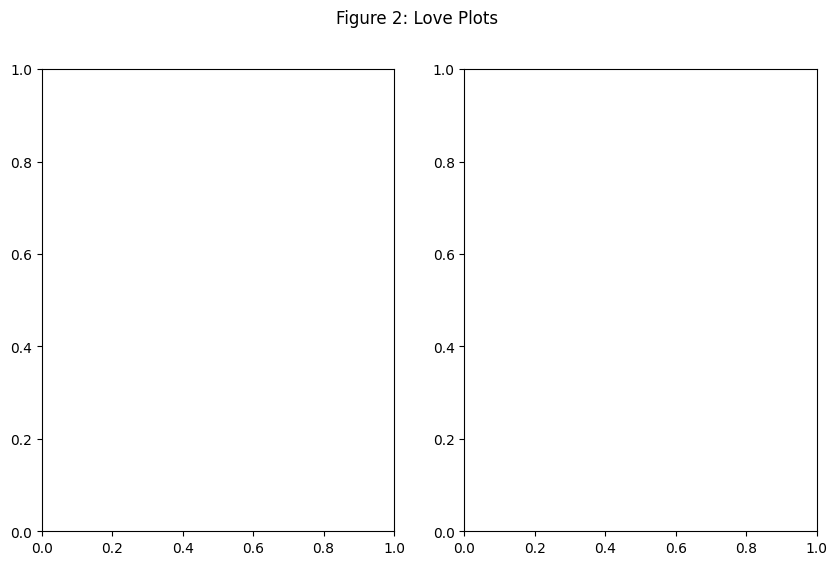

In [5]:
# TODO generate the matched datasets
# matched_df = TODO
# matched_trimmed_df = TODO


# TODO call std_diff_dataframe for the two matched datasets. 
# Be sure to pair matched_df with observational_df, and matched_trimmed_df with trimmed_df
# observational_std_diff = TODO
# trimmed_std_diff = TODO

# TODO plot the Love plots for the two std diff dataframes side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Figure 2: Love Plots')
# covariates = ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75', 'u74', 'u75']

# TODO for both plots, set the x-axis limits to be the same
# axs[0].set_title(TODO)
# axs[0].set_xlim(-2.5, 2.5)

# axs[1].set_title(TODO)
# axs[1].set_xlim(-2.5, 2.5)

# save the figure for viewing later
fig.savefig('fig2_love_plots.png', dpi=300, bbox_inches='tight')

## Estimation

Instead of reporting a table of estimates and confidence intervals, for this project we will generate two figures for illustrating the estimates and confidence intervals for the observational and trimmed datasets. We provide a `build_estimator_error_bars` function that helps generate the error bar plots for the various estimators:

In [6]:
def build_estimator_error_bars(estimator_dict, ax):
    """
    Given a dictionary of estimator results and an axis, generates the error bar plots for the estimators, 
    where the x-axis is the estimator name, the y-axis is the point estimate, and the error bars are the 95% confidence interval.

    Args:
        estimator_dict (dict): A dictionary of estimator results
        ax (plt.Axes): The axis to plot the error bars on

    Returns:
        ax (plt.Axes): The axis with the error bars plotted
    """
    
    est_df = pd.DataFrame(columns=['estimator', 'point_estimate', 'lower_ci', 'upper_ci'])
    for estimator, results in estimator_dict.items():
        est_df = pd.concat([est_df if not est_df.empty else None,
        pd.DataFrame({
            'estimator': [estimator],
            'point_estimate': [results['point_estimate']],
            'lower_ci': [results['ci'][0]],
            'upper_ci': [results['ci'][1]]
        })], ignore_index=True)

    est_df['yerr_lower'] = est_df['point_estimate'] - est_df['lower_ci']
    est_df['yerr_upper'] = est_df['upper_ci'] - est_df['point_estimate']
    
    ax.errorbar(
        x=range(len(est_df)),
        y=est_df['point_estimate'],
        yerr=[est_df['yerr_lower'], est_df['yerr_upper']],
        fmt='o', # draw a circle at each point
        capsize=5, # draw a line at the end of the error bar
        color=sns.color_palette()[0], # use the first color in the seaborncolor palette
        
    )
    ax.set_xticks(range(len(est_df)))
    ax.set_xticklabels(est_df['estimator'])

For example, if we had the following dictionary of estimators:

```python
estimator_dict = {
    'estimator1': {
        'point_estimate': 1.0,
        'ci': [0.9, 1.1]
    },
    'estimator2': {
        'point_estimate': 0.5,
        'ci': [0.4, 0.6]
    },
}
```

The function call `build_estimator_error_bars(estimator_dict, ax)` would generate a plot that looks like this:

<div style="max-width:500px; margin: auto;"> 

![](../images/proj2_example_error_bars.png)

</div>

Begin by generating the results for each estimator using the `generate_estimates` helper function provided earlier in the notebook according to the table below:


|Results Name | estimator_func | data |
|------------|-----------|---------|
| `naive` | `reg_diff_in_means` | `observational_df` |
| `matching` | `reg_diff_in_means` | `trimmed_df` |
| `ipw` | `reg_diff_in_means` | `matched_df` |
| `naive_trimmed` | `reg_diff_in_means` | `trimmed_df` |
| `matching_trimmed` | `reg_diff_in_means` | `matched_trimmed_df` |
| `ipw_trimmed` | `ipw_att` | `trimmed_df` |

In [10]:
# TODO call generate_estimates for each estimator, this cell may take ~20-30 seconds to run
naive = None #generate_estimates(data=observational_df, estimator_func=reg_diff_in_means, treat_col='treat', outcome_col='re78')
matching = None
ipw = None
naive_trimmed = None
matching_trimmed = None
ipw_trimmed = None

**Figure 3**: Build a side by side plot of the estimators for the observational and trimmed datasets. The goal is to produce a plot similar to figure 3 in [Imbens and Xu 2024](https://arxiv.org/abs/2406.00827), except that we will put our two plot panels side by side instead of on top of each other.

<div style="max-width:800px; margin: auto;"> 

![](../images/proj2_imbens_xu_fig3.png)

</div>


We will use the experimental results as reference lines for the true ATT effect (the red lines and regions in Imbens and Xu 2024 above). We'll plot our three estimators (naive, matching, IPW) for the full observational dataset in the left panel, and our three estimators for the trimmed dataset in the right panel. As always, be sure to label the axes and add titles as appropriate. The units of the y-axis are in dollars.

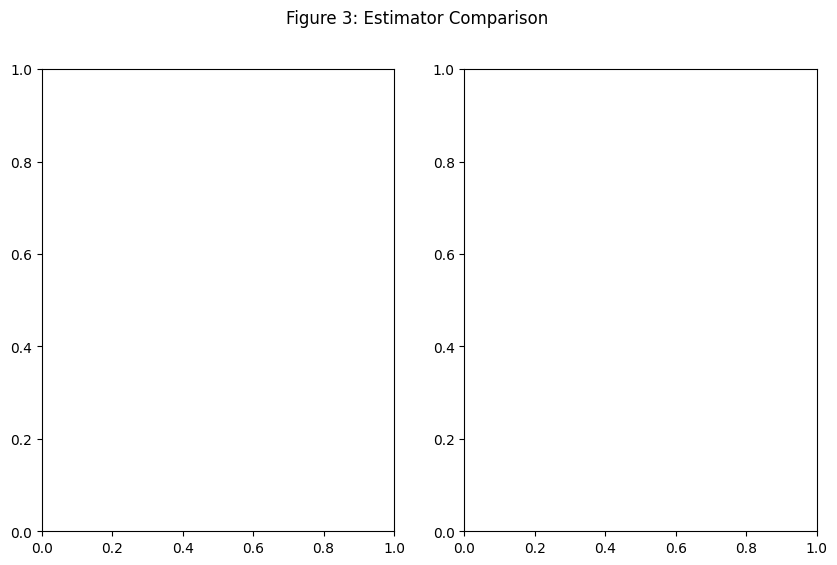

In [11]:
# load in the experimental dataset for a reference line
experimental_df = pd.read_csv('~/COMSC-341CD/data/nsw_experimental.csv')

# TODO call generate_estimates for the experimental dataset using the reg_diff_in_means estimator
experiment_results = None

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Figure 3: Estimator Comparison')

#### axs[0] ####
# axs[0].set_title(TODO)

# TODO plot the experimental point estimate as a horizontal red solid line and the 95% confidence intervals as dotted red lines
# Optionally, you can use ax.fill_between() to shade the 95% confidence interval region
#ax.hline(TODO)

observational_estimators = {
    'naive difference-in-means': naive,
    'matched difference-in-means': matching,
    'IPW': ipw
}

# TODO call the build_estimator_error_bars function for the observational_estimators dictionary
# build_estimator_error_bars(estimator_dict=TODO, ax=TODO)

# fix the y-axis limits to be the same for both plots
# axs[0].set_ylim(-10000, 4000)


#### axs[1] ####
# TODO repeat the same plot as axs[1] for the trimmed estimators, including the experimental reference line and confidence intervals
# axs[1].set_title(TODO)

trimmed_estimators = {
    'naive difference-in-means': naive_trimmed,
    'matched difference-in-means': matching_trimmed,
    'IPW': ipw_trimmed
}
# TODO call the build_estimator_error_bars function for the trimmed_estimators dictionary
# build_estimator_error_bars(estimator_dict=TODO, ax=TODO)

# fix the y-axis limits to be the same for both plots
# axs[0].set_ylim(-10000, 4000)

# save the figure for viewing later
fig.savefig('fig3_estimator_comparison.png', dpi=300, bbox_inches='tight')

# Discussion

:::{tip}

If it is more convenient for you to view your notebook in one window and answer questions in another, you can copy the questions below into a separate document and answer them there. Then, you can copy your responses back into the notebook for submission.

The figures you generated above are also saved and embedded inline below to make it easier to answer the questions. You may need to "refresh" the cell by double-clicking on them and then executing the cell again to view them.

:::

## 2. Prior Knowledge and Causal Question

Given the description of the NSW program above, answer the following questions:

2.1. Briefly discuss why the ATT may be a more appropriate causal quantity to focus on when evaluating the NSW program's effectiveness as opposed to the ATE or ATU.

2.2. Suppose that the observational dataset was collected in a way such that participants self-selected into the program -- in other words, individuals voluntarily chose whether to participate in the program. The study designers then collected the list of covariates above as confounders to satisfy the conditional exchangeability assumption. Given the description of the NSW program, briefly discuss one potential confounder that might be missing from the covariate list. In your discussion, be sure to include why you believe that confounder could affect both an individual's participation in the NSW job training program and their subsequent earnings.

:::{admonition} Note

The reason why the LaLonde and other researchers treat conditional exchangeability as plausible in the real data is because their "observational" dataset is partially constructed from the experimental dataset. Question 2 is operating under the assumption that the observational dataset is fully constructed from the self-selected participants, in which case conditional exchangeability would have been much more difficult to justify.

:::

**TODO your responses**:

2.1:

2.2:




## 3. Design

![](fig1_propensity_score_distribution.png)

![](fig2_love_plots.png)



3.1. Examining your propensity score distributions in Figure 1, does there appear to be any evidence of positivity violations? Are there any regions where the propensity score distribution may be problematic in terms of severe imbalance between the number of treated and control units?

3.2. Looking at the left panel Love plot for the full observational dataset in Figure 2, which covariate was the most unbalanced in the unmatched dataset, and which covariate was most balanced in the unmatched dataset? Does the matching process appear to have been effective at balancing the covariates?

3.3. Comment on what you observe in your right panel Love plot for the trimmed dataset in Figure 2. Does matching seem to be more beneficial for trimmed or untrimmed data?

**TODO your responses**:

3.1:

3.2:

3.3:




## 4. Estimation and Interpretation

![](fig3_estimator_comparison.png)




4.1. Looking at your left panel of estimator results in Figure 3 for the full observational dataset, which estimator appears to be most biased compared to the experimental ATT estimate? Briefly discuss why you think this estimator is biased. Some things to potentially consider are what causal assumptions are being made/violated, or whether covariates are being controlled for.

4.2. Which estimator appears to best match the experimental ATT estimates with the full observational dataset in your left panel of Figure 3? 

4.3. Comment on any changes you observe for all three estimators in the right panel of Figure 3 with the trimmed dataset. Which estimator(s) appear to benefit from trimming the propensity score?

4.4. Given that the causal quantity we have been estimating is the ATT and the experimental point estimate is $1,794, state an interpretation of this result in the context of the treatment and outcome of the study. 

**TODO your responses**:

4.1:

4.2:

4.3:

4.4:




## 5. Reflection

5.1. How much time did you spend on this assignment?

5.2. Were there any parts of the assignment that you found particularly challenging?

5.3. What is one thing you have a better understanding of after completing this assignment and going through the class content?

5.4. Do you have any follow-up questions about concepts that you'd like to explore further?

**TODO your responses**:

5.1:

5.2:

5.3:

5.4:


# Optional Extensions

- We have implemented the most fundamental matching and IPW estimators in this project. There has been extensive work on variations of these estimators, including:
    - K:1 matching, where multiple controls are matched to each treated unit
    - augmented IPW, where the propensity score is augmented with a flexible model
- There have also been explorations of using machine learning methods to estimate the propensity score, and whether these provide better balance and/or more efficient estimators.
- To learn more about how these variations can be implemented, see the latter sections of [Austin 2011](https://pmc.ncbi.nlm.nih.gov/articles/PMC3144483/pdf/hmbr46-399.pdf) and [Imbens and Xu 2024](https://arxiv.org/abs/2406.00827).

# Acknowledgements

This assignment uses data from Nick Huntington-Klein's `causaldata` package, which provides convenient access to the Lalonde dataset. This project is based on Chapter 5 of Scott Cunningham's [Causal Inference: The Mixtape](https://mixtape.scunning.com/) as well as [Imbens and Xu 2024: Lalonde (1986) after Nearly Four Decades: Lessons Learned](https://arxiv.org/abs/2406.00827).